# Aggregating Slice Results: Part 2

In this report, I will explore different ways of aggregating slice deep feature results, in order to evaluate fibrosis presence in patient, rather than individual slices.

This notebook represents the second part of result aggregation analysis, meaning it contains every optimization and change made to the previous notebook. 

In [28]:
# ------------ Utils ------------

from aggregateUtils import * 

# ------------ t-SNE ------------

from sklearn.manifold import TSNE

print(f"Device: {torch.cuda.get_device_name(0)}")

Device: NVIDIA GeForce RTX 3070


In [3]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## Training

In [128]:

class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss
        self.number_images = 0

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        if not os.path.exists(img_path): print(f"Missing file: {img_path}")
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, patient_id

In [129]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [119]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    """
    # Setup ResNet for Reading
    resnet_eval = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    

    # Use only 2 output neurons
    num_ftrs = resnet_eval.fc.in_features
    resnet_eval.fc = nn.Linear(num_ftrs, 2)

    # Load weights
    resnet_eval.load_state_dict(checkpoint['model_state_dict'])

    """

    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate.pkl"))


else: print("Invalid answer, try again.")

Invalid answer, try again.


In [6]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_aggregate.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


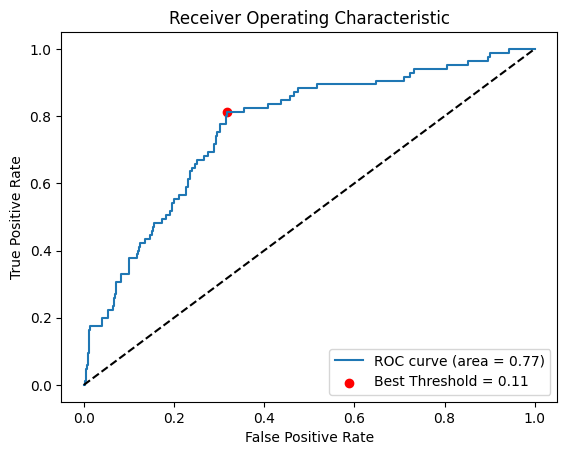

Area Under Curve: 0.7652073973461498
Best Threshold (closest to (0,1)): 0.11222569


In [7]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

# Feature-wise Patient Classification

This will be done through aggregation of the features determined by the final resnet conv layer, for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of features. 
 - another dictionary containing the same keys, but with features derived from the test split.

### <span style = "color:red"> WARNING  </span>

This concept would force me to re-define the best threshold, as the one obtained in the previous notebook was meant for probability-wise aggregation. So, a new individual best_threshold would need to be determined for each aggregation criteria.

However, this is not nearly as easily obtainable as the best classification threshold for probabilites derived by ROC. In this case, I must first visualize the data I'm working with, regarding features. Only then can I search for aggregation methods, and ways to derive the best parameters for each of the techniques.

## Creating hooks

The first step to work on this concept requires "hooking" onto the last block's convolutional layer. This allows me to pull the derived features, instead of obtaining a simple logit/prob/class output.


In [8]:
# Loads the model
resnet18_example = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = resnet18_example.fc.in_features
resnet18_example.fc = nn.Linear(num_ftrs, 2)  

# Visulization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_example.to(device)
summary(resnet18_example, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Or, in a more in-depth look at the network's final block (taken from `3.1 - introAndSetup`):

```md

(layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=2, bias=True)
)

```

A hook is a powerful tool that allows for the execution of code during forward or backward passes. If I intercept the final forward pass to the **fully connected** (fc) layer, I'm able to extract the features.

For this implementation, I will be using an adaptation of [this StackOverflow user](https://stackoverflow.com/questions/78279823/how-exactly-the-forward-and-backward-hooks-work-in-pytorch):

In [9]:
class HookFC: 
    def __init__(self, model, fc='avgpool'):
        self.model = model
        self.intercepts = []
        for name, module in self.model.named_modules():
            if fc in name:
                module.register_forward_hook(self.getFcOutput)

    def getFcOutput(self, module, input, output):
        self.intercepts.append(output.cpu())

    def __call__(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        return self.intercepts

In [79]:
class HookFC:
    def __init__(self, model, fc='avgpool'):
        self.model = model
        self.intercepts = []
        self.hook = None
        for name, module in self.model.named_modules():
            if fc in name:
                # Register hook and save the handle for later removal
                self.hook = module.register_forward_hook(self.getFcOutput)

    def getFcOutput(self, module, input, output):
        # Clear previous outputs on each forward pass to avoid accumulation
        self.intercepts = [output.detach().cpu()]

    def __call__(self, input_tensor):
        self.model.zero_grad()
        _ = self.model(input_tensor)
        return self.intercepts[0]  # Return just the latest output

    def remove(self):
        if self.hook is not None:
            self.hook.remove()
            self.hook = None

However, replacing the fully connected layer with torch.nn.Identity also works perfectly fine. This returns the last pooled vector, avoiding transformation to 2 logits, and also returns a result with higher floating point precision.

The implementation above will be preserved, as it represents a more customizable version of this concept.

## Pulling Features

In [ ]:
def getFeatures(resnet18, train_dataset, val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print("Train dataset length:", len(train_dataset))
    print("Validation dataset length:", len(val_dataset))
    print("Total samples:", len(train_dataset) + len(val_dataset))
    print('-----------------------------------------------------')
    print("Train dataset length:", len(train_loader.dataset))
    print("Validation dataset length:", len(val_loader.dataset))
    print("Total samples:", len(train_loader.dataset) + len(val_loader.dataset))


    print(val_dataset.number_images)

    tsne_features, tsne_labels = [], []

    #resnet18.fc = torch.nn.Identity()
    hook = HookFC(resnet18)

    # This loop populates dictionaries with features pulled from the train_dataset
    # using interceptions made by the model hook
    with torch.no_grad():
        for images, labels, patient_id in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            #outputs = resnet18(images)
            outputs = hook(images)

            # Associate features to labels
            for ftr, label in zip(outputs, labels.tolist()):
                tsne_features.append(ftr.cpu())  # Adds feature to list
                tsne_labels.append(label)

    
    # Same concept, but for validation_dataset
    with torch.no_grad():
        for images, labels, patient_id in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = hook(images)

            # Associate features and labels
            for ftr, label in zip(outputs, labels.tolist()):
                tsne_features.append(ftr.cpu())  # Adds feature to list
                tsne_labels.append(label)
    
    return tsne_features, tsne_labels

In [110]:
features_batch, labels = getFeatures(resnet_eval, train_dataset, val_dataset)

Train dataset length: 1730
Validation dataset length: 648
Total samples: 2378
-----------------------------------------------------
Train dataset length: 1730
Validation dataset length: 648
Total samples: 2378
0


100%|██████████| 21/21 [00:01<00:00, 13.45it/s]


In [111]:
print((features_batch[0]).shape)
train_df, val_df = pd.read_csv(r"..\trainTestCustom\train.csv"), pd.read_csv(r"..\trainTestCustom\val.csv")
print((len(train_df) + len(val_df)))
print(len(features_batch))

torch.Size([512, 1, 1])
2427
2378


The `torch.Size([512, 1, 1])` shape is essentially `([Features, 1, 1])`:
 - **Features**: Number of channels, which is 512 in this case, and represents each feature
 - **1, 1**: Illustrates the spatial resolution being pooled down to a single value, **1*1**

## t-SNE

t-SNE expects shape `(SampleNumber, Dimension)` for **X**, which in this case will be something like `(N, D)` → each element of **X** must be of shape `(512,)`:

In [77]:
features_reshaped = []
for batch in tqdm(features_batch):  # batch.shape == (B, 512, 1, 1)
    batch = batch.squeeze(-1).squeeze(-1)  # (B, 512)
    print(batch.shape)
    for ftr in batch: features_reshaped.append(ftr)  # Each ftr is (512,)
        

 11%|█         | 76/703 [00:00<00:01, 373.27it/s]

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size

 38%|███▊      | 267/703 [00:00<00:00, 1006.85it/s]

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size

100%|██████████| 703/703 [00:00<00:00, 934.02it/s] 

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size

In [78]:
print((features_batch[0]).shape)
print((features_reshaped[0]).shape)
print(len(features_reshaped))

torch.Size([32, 512, 1, 1])
torch.Size([512])
333506


In [57]:
print((features_reshaped[39488]).shape)

torch.Size([])


In [59]:
# Move to cpu for tsne
X = torch.stack([f for f in features_reshaped], dim=0)  # (N, 512)
y = labels   # (N,)


tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', verbose=1)
X_embedded = tsne.fit_transform(X)  # (N, 2)


RuntimeError: stack expects each tensor to be equal size, but got [512] at entry 0 and [] at entry 39488